# Loading Dependencies

In [0]:
import os
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

from keras.activations import relu
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout, concatenate
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report

from IPython.display import SVG

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Helper Functions

In [0]:
def compute_metrics(raw_predictions, label_encoder):
    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]

    # convert raw predictions to class indexes
    threshold = 0.5
    class_predictions = [(x > threshold).astype(int) for x in model.predict(x_test)]

    # select only one class (i.e., the dim in the vector with 1.0 all other are at 0.0)
    class_index = ([np.argmax(x) for x in class_predictions])

    # convert back to original class names
    pred_classes = label_encoder.inverse_transform(class_index)

    # print precision, recall, f1-score report
    print(classification_report(y_test, pred_classes))
    
def load_fasttext_embeddings():
    glove_dir = './data'
    embeddings_index = {}
    f = open(os.path.join(glove_dir, 'glove.6B.300d.txt')) # word2vec vectors that were trained on 100 billion words from Google News.
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index
  
def create_embeddings_matrix(embeddings_index, vocabulary, embedding_dim=100):
    embeddings_matrix = np.random.rand(len(vocabulary)+1, embedding_dim)
    for i, word in enumerate(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
    print('Matrix shape: {}'.format(embeddings_matrix.shape))
    return embeddings_matrix
  
def get_embeddings_layer(embeddings_matrix, name, max_len, trainable=False):
    embedding_layer = Embedding(
        input_dim=embeddings_matrix.shape[0],
        output_dim=embeddings_matrix.shape[1],
        input_length=max_len,
        weights=[embeddings_matrix],
        trainable=trainable,
        name=name)
    return embedding_layer
  
def get_conv_pool(x_input, sufix, n_grams=[3,4,5], feature_maps=100):
    branches = []
    for n in n_grams:
        branch = Conv1D(filters=feature_maps, kernel_size=n, activation=relu, name='Conv_'+sufix+'_'+str(n))(x_input)
        #branch = MaxPooling1D(pool_size=2, strides=None, padding='valid', name='MaxPooling_'+sufix+'_'+str(n))(branch)
        branch = GlobalMaxPooling1D(name='MaxPooling_'+sufix+'_'+str(n))(branch)
        #branch = Flatten(name='Flatten_'+sufix+'_'+str(n))(branch)
        branches.append(branch)
    return branches

# Models

## 1) CNN-rand: all words are randomly initialized (the ones not present in the set of pre-trained words) and then modified during training

In [0]:
def get_cnn_rand(embedding_dim=100, vocab_size=1000, max_len=50):
    # create the embedding layer
    embedding_matrix = np.random.rand(vocab_size, embedding_dim)
    embedding_layer = get_embeddings_layer(embedding_matrix, 'embedding_layer_dynamic', max_len, trainable=True)

    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'dynamic')
    z = concatenate(branches, axis=-1)
    z = Dropout(0.8)(z)

    # pass the concatenated vector to the predition layer
    o = Dense(2, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam', metrics=['acc'])

    return model

In [0]:
model_1 = get_cnn_rand(vocab_size=100000, max_len=100)

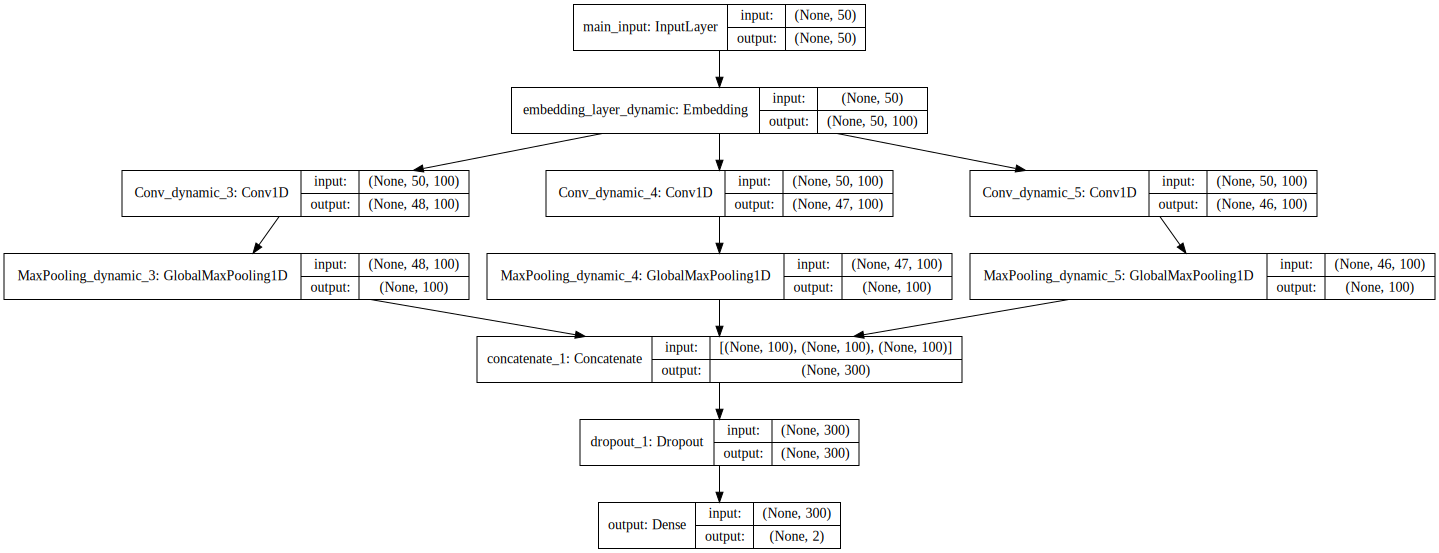

In [0]:
SVG(model_to_dot(model_1, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

## 2) CNN-static: pre-trained vectors with all the words— including the unknown ones that are randomly initialized—kept static and only the other parameters of the model are learned

In [0]:
embeddings_index = load_fasttext_embeddings()

Found 400000 word vectors.


In [0]:
vocabulary = embeddings_index.keys() # replace this by the vocabulary of the dataset you want to train
embeddings_matrix = create_embeddings_matrix(embeddings_index, vocabulary, 300)

Matrix shape: (400001, 300)


In [0]:
embedding_layer = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', 55, trainable=False)

In [0]:
def get_cnn_pre_trained_embeddings(embedding_layer, max_len):
    # connect the input with the embedding layer
    i = Input(shape=(max_len,), dtype='int32', name='main_input')
    x = embedding_layer(i)

    # generate several branches in the network, each for a different convolution+pooling operation,
    # and concatenate the result of each branch into a single vector
    branches = get_conv_pool(x, 'static')
    z = concatenate(branches, axis=-1)

    # pass the concatenated vector to the predition layer
    o = Dense(2, activation='sigmoid', name='output')(z)

    model = Model(inputs=i, outputs=o)
    model.compile(loss={'output': 'binary_crossentropy'}, optimizer='adam', metrics=['acc'])

    return model

In [0]:
model_2 = get_cnn_pre_trained_embeddings(embedding_layer, 55)

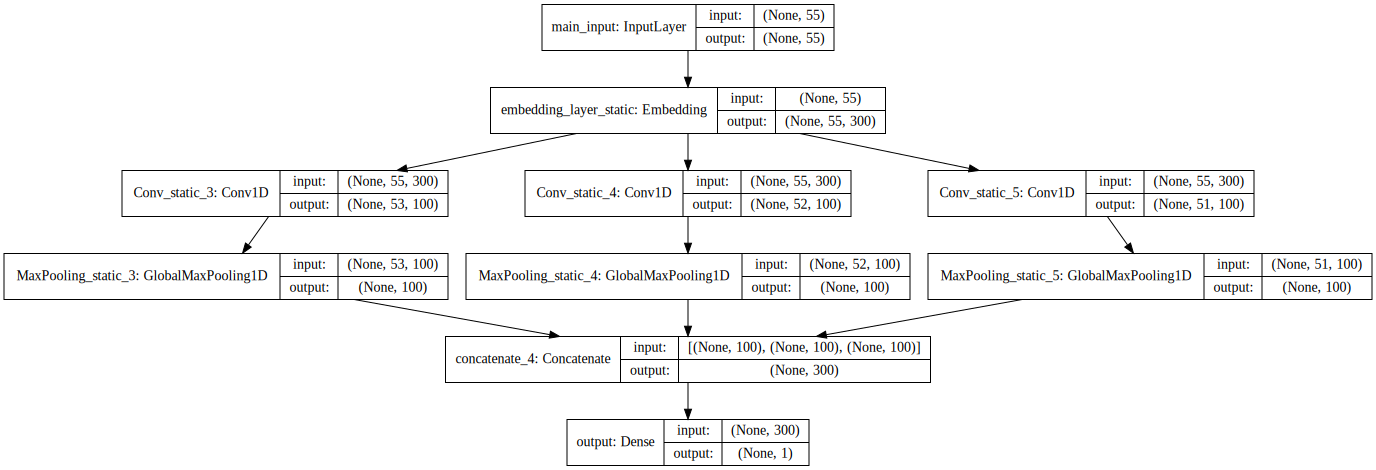

In [0]:
SVG(model_to_dot(model_2, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

# Loading Data

## Movie Review

In [0]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet');

# use nltk to remove stopwords and lemmatize
# you might need to run: nltk.download() to fetch the stopword package in "all packages"
# you might also need to run ntlk.download("punkt")
english_stopwords = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()

MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 55
TEST_SPLIT = 0.2

def clean_input_text(text):
    clean_text = []
    for sent in text:
        clean_sent = ""
        sent_tokens = word_tokenize(sent)
        for token in sent_tokens:
            clean_sent += wordnet_lemmatizer.lemmatize(token) + " " if token not in english_stopwords else ""
        clean_text.append(clean_sent)
    return clean_text
  
  # Movie Review
  
# def retrieve_examples_and_labels(dataset_name):
#     labels, x_text = [],[]
#     directory = 'gdrive/My Drive/COMP 551 - Mini Project 4 - Final Project/rt-polaritydata'
#     with open(os.path.join(directory,dataset_name), encoding="utf-8") as f:
#       for line in f:
#         if dataset_name == 'rt-polarity.neg':
#           label = 0
#         elif dataset_name == 'rt-polarity.pos':
#           label = 1
#         text = line
#         labels.append(label)
#         x_text.append(text)
#     return x_text, labels

# x_text1, y_train1 = retrieve_examples_and_labels("rt-polarity.neg")
# x_text2, y_train2 = retrieve_examples_and_labels("rt-polarity.pos")
# x_text = clean_input_text(x_text1 + x_text2)
# y = y_train1 + y_train2

# SST2

#retrieve all sentences and their labels from the sst dataset

# def retrieve_examples_and_labels(dataset_name):
#     labels, x_text = [],[]
#     with open(dataset_name, encoding="utf-8") as f:
#       for line in f:
#         values = line.split()
#         label = values[0]
#         text = " ".join(values[1:])
#         labels.append(label)
#         x_text.append(text)
#     return x_text, labels

# x_text1, y_train1 = retrieve_examples_and_labels("train.txt")
# x_text2, y_train2 = retrieve_examples_and_labels("test.txt")
# x_text = clean_input_text(x_text1 + x_text2)
# y = y_train1 + y_train2

# CR

def load_reviews_dataset():

    products = ["Apex AD2600 Progressive-scan DVD player.txt"
    ,"Canon G3.txt"
    ,"Creative Labs Nomad Jukebox Zen Xtra 40GB.txt"
    ,"Nikon coolpix 4300.txt"
    ,"Nokia 6610.txt"]
    examples = []
    for product in products:
        examples += list(open('./data/customer_reviews/' + product, "r", encoding="utf-8").readlines())
    
    # for every examples, keep the one starting with a ranking
    x_text, y = [],[]
    for example in examples:
        final_label = 0
        temp_split = example.split("##")
        # don't consider unlabeled sentences
        if len(temp_split) <= 1:
            continue
        temp_label, temp_sentence = temp_split
        # parse the temp_label to find positive or negative
        positive_label = temp_label.split("+")
        #print("len positive label: {}".format(len(positive_label)))
        if len(positive_label) > 1:
            final_label = 1
        
        # so the final_label is either 0 or 1, 0 if negative, 1 if positive
        final_sentence = clean_str(temp_sentence.strip())
        x_text.append(final_sentence)
        y.append(final_label)
    return x_text, y
        
        
x_text, y = load_reviews_dataset()
x_text = clean_input_text(x_text)

# vectorize the input text (both negative and positive )
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_text)
sequences = tokenizer.texts_to_sequences(x_text)
print(sequences[0])
word_index = tokenizer.word_index
print(len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(y),num_classes=None)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
 

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_all, x_test, y_all, y_test = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=TEST_SPLIT, random_state=42)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[1815, 1447, 1448, 1449, 39, 273, 287]
4573
Shape of data tensor: (3944, 55)
Shape of label tensor: (3944, 2)


# Running Models

In [0]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model_1.summary()

## Movie Review

In [0]:
model_1.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_val, y_val))
score = model_1.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 6823 samples, validate on 1706 samples
Epoch 1/50
6823/6823 [==============================] - 2s 241us/step - loss: 0.7381 - acc: 0.6327 - val_loss: 0.5144 - val_acc: 0.8159
Epoch 2/50
6823/6823 [==============================] - 2s 230us/step - loss: 0.5934 - acc: 0.6624 - val_loss: 0.4928 - val_acc: 0.8244
Epoch 3/50
6823/6823 [==============================] - 2s 230us/step - loss: 0.5495 - acc: 0.7115 - val_loss: 0.4390 - val_acc: 0.8508
Epoch 4/50
6823/6823 [==============================] - 2s 232us/step - loss: 0.4901 - acc: 0.7564 - val_loss: 0.3966 - val_acc: 0.8658
Epoch 5/50
6823/6823 [==============================] - 2s 230us/step - loss: 0.4340 - acc: 0.7966 - val_loss: 0.3987 - val_acc: 0.8666
Epoch 6/50
6823/6823 [==============================] - 2s 232us/step - loss: 0.3902 - acc: 0.8127 - val_loss: 0.3908 - val_acc: 0.8669
Epoch 7/50
6823/6823 [==============================] - 2s 231us/step - loss: 0.3648 - acc: 0.8338 - val_loss: 0.3880 - val_acc: 0.8702


## SST 2

In [0]:
model_1.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_val, y_val))
score = model_1.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 5593 samples, validate on 1399 samples
Epoch 1/50
5593/5593 [==============================] - 1s 248us/step - loss: 0.8833 - acc: 0.5712 - val_loss: 0.5498 - val_acc: 0.8306
Epoch 2/50
5593/5593 [==============================] - 1s 229us/step - loss: 0.6186 - acc: 0.6148 - val_loss: 0.4650 - val_acc: 0.8603
Epoch 3/50
5593/5593 [==============================] - 1s 229us/step - loss: 0.5822 - acc: 0.6476 - val_loss: 0.4686 - val_acc: 0.8567
Epoch 4/50
5593/5593 [==============================] - 1s 232us/step - loss: 0.5742 - acc: 0.6520 - val_loss: 0.4482 - val_acc: 0.8695
Epoch 5/50
5593/5593 [==============================] - 1s 228us/step - loss: 0.5517 - acc: 0.6696 - val_loss: 0.4401 - val_acc: 0.8603
Epoch 6/50
5593/5593 [==============================] - 1s 229us/step - loss: 0.5280 - acc: 0.6827 - val_loss: 0.4312 - val_acc: 0.8628
Epoch 7/50
5593/5593 [==============================] - 1s 230us/step - loss: 0.5043 - acc: 0.7083 - val_loss: 0.4242 - val_acc: 0.8670


## Customer Review

In [0]:
model_1.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_val, y_val))
score = model_1.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 2524 samples, validate on 631 samples
Epoch 1/50
2524/2524 [==============================] - 1s 275us/step - loss: 1.4129 - acc: 0.6605 - val_loss: 0.6394 - val_acc: 0.7227
Epoch 2/50
2524/2524 [==============================] - 1s 233us/step - loss: 0.6188 - acc: 0.7199 - val_loss: 0.5891 - val_acc: 0.7227
Epoch 3/50
2524/2524 [==============================] - 1s 234us/step - loss: 0.5987 - acc: 0.7189 - val_loss: 0.5888 - val_acc: 0.7227
Epoch 4/50
2524/2524 [==============================] - 1s 228us/step - loss: 0.5983 - acc: 0.7191 - val_loss: 0.5896 - val_acc: 0.7227
Epoch 5/50
2524/2524 [==============================] - 1s 230us/step - loss: 0.5910 - acc: 0.7203 - val_loss: 0.5901 - val_acc: 0.7227
Epoch 6/50
2524/2524 [==============================] - 1s 228us/step - loss: 0.5928 - acc: 0.7195 - val_loss: 0.5906 - val_acc: 0.7227
Epoch 7/50
2524/2524 [==============================] - 1s 231us/step - loss: 0.5913 - acc: 0.7203 - val_loss: 0.5909 - val_acc: 0.7227
E

## CNN-Static

### MR

In [0]:
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 55)           0                                            
__________________________________________________________________________________________________
embedding_layer_static (Embeddi (None, 55, 300)      120000300   main_input[0][0]                 
__________________________________________________________________________________________________
Conv_static_3 (Conv1D)          (None, 53, 100)      90100       embedding_layer_static[1][0]     
__________________________________________________________________________________________________
Conv_static_4 (Conv1D)          (None, 52, 100)      120100      embedding_layer_static[1][0]     
__________________________________________________________________________________________________
Conv_stati

In [0]:
model_2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 6823 samples, validate on 1706 samples
Epoch 1/10
6823/6823 [==============================] - 1s 143us/step - loss: 0.7078 - acc: 0.7454 - val_loss: 0.5904 - val_acc: 0.7740
Epoch 2/10
6823/6823 [==============================] - 1s 123us/step - loss: 0.0967 - acc: 0.9696 - val_loss: 0.4609 - val_acc: 0.8157
Epoch 3/10
6823/6823 [==============================] - 1s 123us/step - loss: 0.0284 - acc: 0.9980 - val_loss: 0.4484 - val_acc: 0.8253
Epoch 4/10
6823/6823 [==============================] - 1s 122us/step - loss: 0.0179 - acc: 0.9993 - val_loss: 0.4494 - val_acc: 0.8291
Epoch 5/10
6823/6823 [==============================] - 1s 122us/step - loss: 0.0139 - acc: 0.9999 - val_loss: 0.4485 - val_acc: 0.8288
Epoch 6/10
6823/6823 [==============================] - 1s 123us/step - loss: 0.0114 - acc: 0.9999 - val_loss: 0.4505 - val_acc: 0.8315
Epoch 7/10
6823/6823 [==============================] - 1s 124us/step - loss: 0.0098 - acc: 0.9999 - val_loss: 0.4541 - val_acc: 0.8288


In [0]:
print(y_test[0])

[0. 1.]


### SST2

In [0]:
model_2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 5593 samples, validate on 1399 samples
Epoch 1/10
5593/5593 [==============================] - 1s 147us/step - loss: 0.7282 - acc: 0.7828 - val_loss: 0.5161 - val_acc: 0.8199
Epoch 2/10
5593/5593 [==============================] - 1s 123us/step - loss: 0.1069 - acc: 0.9628 - val_loss: 0.4380 - val_acc: 0.8420
Epoch 3/10
5593/5593 [==============================] - 1s 123us/step - loss: 0.0292 - acc: 0.9966 - val_loss: 0.4225 - val_acc: 0.8510
Epoch 4/10
5593/5593 [==============================] - 1s 121us/step - loss: 0.0172 - acc: 0.9986 - val_loss: 0.4236 - val_acc: 0.8520
Epoch 5/10
5593/5593 [==============================] - 1s 122us/step - loss: 0.0137 - acc: 0.9992 - val_loss: 0.4234 - val_acc: 0.8538
Epoch 6/10
5593/5593 [==============================] - 1s 122us/step - loss: 0.0115 - acc: 0.9994 - val_loss: 0.4260 - val_acc: 0.8545
Epoch 7/10
5593/5593 [==============================] - 1s 122us/step - loss: 0.0101 - acc: 0.9993 - val_loss: 0.4242 - val_acc: 0.8560


### CR

In [0]:
model_2.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))
score = model_2.evaluate(x_test, y_test, verbose=0)
print('Test loss:',score[0])
print('Test accuracy:', score[1])

Train on 2524 samples, validate on 631 samples
Epoch 1/10
2524/2524 [==============================] - 0s 127us/step - loss: 0.0037 - acc: 0.9988 - val_loss: 0.3294 - val_acc: 0.8930
Epoch 2/10
2524/2524 [==============================] - 0s 125us/step - loss: 0.0036 - acc: 0.9986 - val_loss: 0.3333 - val_acc: 0.8914
Epoch 3/10
2524/2524 [==============================] - 0s 122us/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.3429 - val_acc: 0.8899
Epoch 4/10
2524/2524 [==============================] - 0s 123us/step - loss: 0.0035 - acc: 0.9984 - val_loss: 0.3300 - val_acc: 0.8938
Epoch 5/10
2524/2524 [==============================] - 0s 123us/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.3335 - val_acc: 0.8914
Epoch 6/10
2524/2524 [==============================] - 0s 125us/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.3385 - val_acc: 0.8899
Epoch 7/10
2524/2524 [==============================] - 0s 124us/step - loss: 0.0032 - acc: 0.9988 - val_loss: 0.3376 - val_acc: 0.8906
E